In [1]:
"""
This script demonstrates how use the APRP method to compute TOA SW radiation anomalies 
due to individual components 

We do this for the difference between piClim-aer and piClim-control RFMIP experiments 
for the ACCESS-CM2 model

input: total cloud cover and SW radiative fluxes at TOA and SFC for clear- and all-sky conditions
       -standard CMIP nomenclature: clt,rsdt,rsut,rsutcs,rsds,rsus,rsdscs,rsuscs
       -flag to do forward, backward, or avg of forward / backward calcuations (the default)

output: TOA SW anomalies due to changes in:
        -surface albedo (for all-, clear-, and overcast-sky conditions)
        -clouds (total change and contributions from changing cloud cover, scattering, and absorption)
        -non-cloud atmosphere (e.g., from changes in water vapor, aerosols, ozone)

Equation numbers throughout refer to Taylor et al. (2007)

Reference:
Taylor, K. E. et al. (2007), Estimating shortwave radiative forcing and response in 
    climate models, J. Clim., 20(11), 2530-2543, doi:10.1175/JCLI4143.1.  

This code is updated from demonstrate_APRP.py  (Jan 2023):
    -all calls to CDAT and Basemap replaced with xarray, xcdat, and cartopy
    -cleans up a variety of other bad coding practices
    -adds the option of doing forward, backward, or (default) the avg of both calculations
    
Contact: Mark Zelinka (zelinka1@llnl.gov)
"""
 
#IMPORT STUFF:
#=====================
import xcdat as xc
import xarray as xr
import numpy as np
import pylab as plt
import matplotlib as mpl
import cartopy.crs as ccrs  # cartopy for plotting maps

 
###########################################################################
# HELPFUL FUNCTIONS FOLLOW
###########################################################################
###########################################################################
def albedo(c,a_clr,a_oc,mu_clr,mu_cld,ga_clr,ga_cld):

    mu_oc=mu_clr*mu_cld # Eq. 14
    ga_oc=1-(1-ga_clr)*(1-ga_cld) # Eq. 13
    A_clr=(mu_clr*ga_clr) + ((mu_clr*a_clr*(1-ga_clr)**2)/(1-(a_clr*ga_clr))) # Eq. 7
    A_oc= (mu_oc*ga_oc)   + ((mu_oc*a_oc*(1-ga_oc)**2)/(1-(a_oc*ga_oc))) # Eq. 7
    A=(1-c)*A_clr + c*A_oc # Eq. 15

    return A 

    
###########################################################################
def parameters(SWupsfccs,SWdnsfccs,SWdn,SWupcs,SWupsfcoc,SWdnsfcoc,SWupoc):
    
    # clear sky parameters
    a_clr=SWupsfccs/SWdnsfccs # albedo
    Q=SWdnsfccs/SWdn # ratio of incident sfc flux to TOA insolation
    mu_clr=SWupcs/SWdn + Q*(1-a_clr) # Eq. 9
    ga_clr=(mu_clr-Q)/(mu_clr-a_clr*Q) # Eq. 10

    # overcast parameters
    a_oc=SWupsfcoc/SWdnsfcoc # albedo
    Q=SWdnsfcoc/SWdn # ratio of incident sfc flux to TOA insolation
    mu_oc=SWupoc/SWdn + Q*(1-a_oc) # Eq. 9
    ga_oc=(mu_oc-Q)/(mu_oc-a_oc*Q) # Eq. 10

    # cloud parameters
    mu_cld=mu_oc/mu_clr  # Eq. 14 sometimes this is greater than 1??
    ga_cld=(ga_oc-1)/(1-ga_clr)+1  # Eq. 13

    return (a_clr,mu_clr,ga_clr,a_oc,mu_cld,ga_cld) 

###########################################################################
def APRP(CTL,PERT,flag=''):

    # Get stuff out of the dictionary, give control values suffix of 1, perturbed suffix of 2:
    clt1,clt2 = CTL['clt'],PERT['clt']
    rsdt1,rsdt2 = CTL['rsdt'],PERT['rsdt']
    rsut1,rsut2 = CTL['rsut'],PERT['rsut']
    rsutcs1,rsutcs2 = CTL['rsutcs'],PERT['rsutcs']
    rsds1,rsds2 = CTL['rsds'],PERT['rsds']
    rsus1,rsus2 = CTL['rsus'],PERT['rsus']
    rsdscs1,rsdscs2 = CTL['rsdscs'],PERT['rsdscs']
    rsuscs1,rsuscs2 = CTL['rsuscs'],PERT['rsuscs']

    
    # Make sure the cld fractions are expressed as fraction and not percent
    if np.max(clt1)>1.:
        clt1=clt1/100.
    if np.max(clt2)>1.:
        clt2=clt2/100.

    # Derive overcast conditions
    rsutoc1=(1/clt1)*(rsut1-(1-clt1)*rsutcs1)
    rsdsoc1=(1/clt1)*(rsds1-(1-clt1)*rsdscs1)
    rsusoc1=(1/clt1)*(rsus1-(1-clt1)*rsuscs1)
    rsutoc2=(1/clt2)*(rsut2-(1-clt2)*rsutcs2)
    rsdsoc2=(1/clt2)*(rsds2-(1-clt2)*rsdscs2)
    rsusoc2=(1/clt2)*(rsus2-(1-clt2)*rsuscs2)

    # Mask these where values are unphysical 
    rsdsoc1=xr.where(rsdsoc1 > rsds1,np.nan,rsdsoc1)   
    rsusoc1=xr.where(rsusoc1 > rsus1,np.nan,rsusoc1)
    rsutoc1=xr.where(rsutoc1 < 0,np.nan,rsutoc1)
    rsdsoc1=xr.where(rsdsoc1 < 0,np.nan,rsdsoc1)
    rsusoc1=xr.where(rsusoc1 < 0,np.nan,rsusoc1)

    rsdsoc2=xr.where(rsdsoc2 > rsds2,np.nan,rsdsoc2)
    rsusoc2=xr.where(rsusoc2 > rsus2,np.nan,rsusoc2)
    rsutoc2=xr.where(rsutoc2 < 0,np.nan,rsutoc2)
    rsdsoc2=xr.where(rsdsoc2 < 0,np.nan,rsdsoc2)
    rsusoc2=xr.where(rsusoc2 < 0,np.nan,rsusoc2)    

    ## NOW THE FORMAL APRP CALCULATIONS:
    a_clr1,mu_clr1,ga_clr1,a_oc1,mu_cld1,ga_cld1 = \
        parameters(rsuscs1,rsdscs1,rsdt1,rsutcs1,rsusoc1,rsdsoc1,rsutoc1) # control
    a_clr2,mu_clr2,ga_clr2,a_oc2,mu_cld2,ga_cld2 = \
        parameters(rsuscs2,rsdscs2,rsdt2,rsutcs2,rsusoc2,rsdsoc2,rsutoc2) # perturbed    

    ## Taylor et al. (2007) Eqn. 12b:
    A_1=albedo(clt1,a_clr1,a_oc1,mu_clr1,mu_cld1,ga_clr1,ga_cld1)
    A_2=albedo(clt2,a_clr2,a_oc2,mu_clr2,mu_cld2,ga_clr2,ga_cld2)

   
    # Forward PRP calculation:
    dA_amt_cld_fwd=     albedo(clt2,a_clr1,a_oc1,mu_clr1,mu_cld1,ga_clr1,ga_cld1)-A_1 # 16b.3
    dA_a_clr_fwd=       albedo(clt1,a_clr2,a_oc1,mu_clr1,mu_cld1,ga_clr1,ga_cld1)-A_1 # 16a.1
    dA_a_oc_fwd=        albedo(clt1,a_clr1,a_oc2,mu_clr1,mu_cld1,ga_clr1,ga_cld1)-A_1 # 16a.2
    dA_abs_noncld_fwd=  albedo(clt1,a_clr1,a_oc1,mu_clr2,mu_cld1,ga_clr1,ga_cld1)-A_1 # 16c.1
    dA_abs_cld_fwd=     albedo(clt1,a_clr1,a_oc1,mu_clr1,mu_cld2,ga_clr1,ga_cld1)-A_1 # 16b.1
    dA_scat_noncld_fwd= albedo(clt1,a_clr1,a_oc1,mu_clr1,mu_cld1,ga_clr2,ga_cld1)-A_1 # 16c.2
    dA_scat_cld_fwd=    albedo(clt1,a_clr1,a_oc1,mu_clr1,mu_cld1,ga_clr1,ga_cld2)-A_1 # 16b.2

    # Backward PRP calculation:
    dA_amt_cld_bwd=    A_2-albedo(clt1,a_clr2,a_oc2,mu_clr2,mu_cld2,ga_clr2,ga_cld2)
    dA_a_clr_bwd=      A_2-albedo(clt2,a_clr1,a_oc2,mu_clr2,mu_cld2,ga_clr2,ga_cld2)
    dA_a_oc_bwd=       A_2-albedo(clt2,a_clr2,a_oc1,mu_clr2,mu_cld2,ga_clr2,ga_cld2)
    dA_abs_noncld_bwd= A_2-albedo(clt2,a_clr2,a_oc2,mu_clr1,mu_cld2,ga_clr2,ga_cld2)
    dA_abs_cld_bwd=    A_2-albedo(clt2,a_clr2,a_oc2,mu_clr2,mu_cld1,ga_clr2,ga_cld2)
    dA_scat_noncld_bwd=A_2-albedo(clt2,a_clr2,a_oc2,mu_clr2,mu_cld2,ga_clr1,ga_cld2)
    dA_scat_cld_bwd=   A_2-albedo(clt2,a_clr2,a_oc2,mu_clr2,mu_cld2,ga_clr2,ga_cld1)

    if flag=='': # do forward and backward PRP (default)
        dA_amt_cld =    0.5*(dA_amt_cld_fwd + dA_amt_cld_bwd)
        dA_a_clr =      0.5*(dA_a_clr_fwd + dA_a_clr_bwd) 
        dA_a_oc =       0.5*(dA_a_oc_fwd + dA_a_oc_bwd)
        dA_abs_noncld = 0.5*(dA_abs_noncld_fwd + dA_abs_noncld_bwd)
        dA_abs_cld =    0.5*(dA_abs_cld_fwd + dA_abs_cld_bwd)
        dA_scat_noncld =0.5*(dA_scat_noncld_fwd + dA_scat_noncld_bwd)
        dA_scat_cld =   0.5*(dA_scat_cld_fwd + dA_scat_cld_bwd)        
    elif flag=='forward': # do forward-only PRP  
        dA_amt_cld = dA_amt_cld_fwd
        dA_a_clr = dA_a_clr_fwd
        dA_a_oc = dA_a_oc_fwd
        dA_abs_noncld = dA_abs_noncld_fwd
        dA_abs_cld = dA_abs_cld_fwd
        dA_scat_noncld = dA_scat_noncld_fwd
        dA_scat_cld = dA_scat_cld_fwd      
    elif flag=='backward': # do backward-only PRP
        dA_amt_cld = dA_amt_cld_bwd
        dA_a_clr = dA_a_clr_bwd
        dA_a_oc = dA_a_oc_bwd
        dA_abs_noncld = dA_abs_noncld_bwd
        dA_abs_cld = dA_abs_cld_bwd
        dA_scat_noncld = dA_scat_noncld_bwd
        dA_scat_cld = dA_scat_cld_bwd

        
    # if the cld fraction is less than 2%, set fields to be zero
    dA_amt_cld=xr.where(clt1<0.02,0.,dA_amt_cld)
    dA_amt_cld=xr.where(clt2<0.02,0.,dA_amt_cld)
    dA_a_oc=xr.where(clt1<0.02,0.,dA_a_oc)
    dA_a_oc=xr.where(clt2<0.02,0.,dA_a_oc)
    dA_abs_cld=xr.where(clt1<0.02,0.,dA_abs_cld)
    dA_abs_cld=xr.where(clt2<0.02,0.,dA_abs_cld)
    dA_scat_cld=xr.where(clt1<0.02,0.,dA_scat_cld)
    dA_scat_cld=xr.where(clt2<0.02,0.,dA_scat_cld)

    dA_a=dA_a_clr+dA_a_oc
    dA_cld=dA_abs_cld+dA_scat_cld+dA_amt_cld
    dA_noncld=dA_abs_noncld+dA_scat_noncld

    ## TOA SW Anomalies due to Surface Albedo Anomalies
    sfc_alb=-dA_a*rsdt1
    sfc_alb_clr=-dA_a_clr*rsdt1   
    sfc_alb_oc=-dA_a_oc*rsdt1

    ## TOA SW Anomalies due to Cloud Anomalies
    cld=-dA_cld*rsdt1
    cld_amt=-dA_amt_cld*rsdt1    
    cld_scat=-dA_scat_cld*rsdt1
    cld_abs=-dA_abs_cld*rsdt1

    ## TOA SW Anomalies due to Non-cloud Anomalies
    noncld=-dA_noncld*rsdt1
    noncld_scat=-dA_scat_noncld*rsdt1  
    noncld_abs=-dA_abs_noncld*rsdt1
    
    # set fields to zero when incoming solar radiation is zero
    sfc_alb=xr.where(rsdt1<0.1,0.,sfc_alb)
    cld=xr.where(rsdt1<0.1,0.,cld)
    noncld=xr.where(rsdt1<0.1,0.,noncld)
    sfc_alb_clr=xr.where(rsdt1<0.1,0.,sfc_alb_clr)
    sfc_alb_oc=xr.where(rsdt1<0.1,0.,sfc_alb_oc)
    cld_amt=xr.where(rsdt1<0.1,0.,cld_amt)
    cld_scat=xr.where(rsdt1<0.1,0.,cld_scat)
    cld_abs=xr.where(rsdt1<0.1,0.,cld_abs)
    noncld_scat=xr.where(rsdt1<0.1,0.,noncld_scat)
    noncld_abs=xr.where(rsdt1<0.1,0.,noncld_abs)

    # store in a dataset:
    TIME = sfc_alb.time
    LAT = sfc_alb.lat
    LON = sfc_alb.lon
    DS = xr.Dataset(
    {
        'sfc_alb':(('time','lat','lon'),sfc_alb.data),
        'sfc_alb_clr':(('time','lat','lon'),sfc_alb_clr.data),
        'sfc_alb_oc':(('time','lat','lon'),sfc_alb_oc.data),
        'cld':(('time','lat','lon'),cld.data),
        'cld_amt':(('time','lat','lon'),cld_amt.data),
        'cld_scat':(('time','lat','lon'),cld_scat.data),
        'cld_abs':(('time','lat','lon'),cld_abs.data),
        'noncld':(('time','lat','lon'),noncld.data),
        'noncld_scat':(('time','lat','lon'),noncld_scat.data),
        'noncld_abs':(('time','lat','lon'),noncld_abs.data),
    },
    coords={'time': TIME,'lat': LAT,'lon': LON},
    ) 
    DS.lat.attrs["axis"] = "Y"
    DS.lon.attrs["axis"] = "X"
    ds = DS.bounds.add_missing_bounds()
    return ds


In [2]:
variables = ['clt','rsdt','rsut','rsutcs','rsds','rsus','rsdscs','rsuscs']
exps = ['piClim-control','piClim-aer']
url = 'http://esgf.nci.org.au/thredds/dodsC/master/CMIP6/RFMIP/CSIRO-ARCCSS/ACCESS-CM2/'
DATA={}
for exp in exps:
    DATA[exp]={}
    for var in variables:
        if exp=='piClim-control':
            prefix = url+exp+'/r1i1p1f1/Amon/'+var+'/gn/v20200428/'
        else:
            prefix = url+exp+'/r1i1p1f1/Amon/'+var+'/gn/v20200428/'
        filename = var+'_Amon_ACCESS-CM2_'+exp+'_r1i1p1f1_gn_096001-098912.nc'
        ds = xc.open_dataset(prefix+filename)
        # Compute climatological annual cycle:
        climo = ds.temporal.climatology(var, 'month', weighted=True)
        DATA[exp][var] = climo[var]
ds = APRP(DATA['piClim-control'],DATA['piClim-aer'])

Done with piClim-control.clt
Done with piClim-control.rsdt
Done with piClim-control.rsut
Done with piClim-control.rsutcs
Done with piClim-control.rsds
Done with piClim-control.rsus
Done with piClim-control.rsdscs
Done with piClim-control.rsuscs
Done with piClim-aer.clt
Done with piClim-aer.rsdt
Done with piClim-aer.rsut
Done with piClim-aer.rsutcs
Done with piClim-aer.rsds
Done with piClim-aer.rsus
Done with piClim-aer.rsdscs
Done with piClim-aer.rsuscs


2023-01-26 13:45:57,402 [WARNING]: bounds.py(_create_bounds:396) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


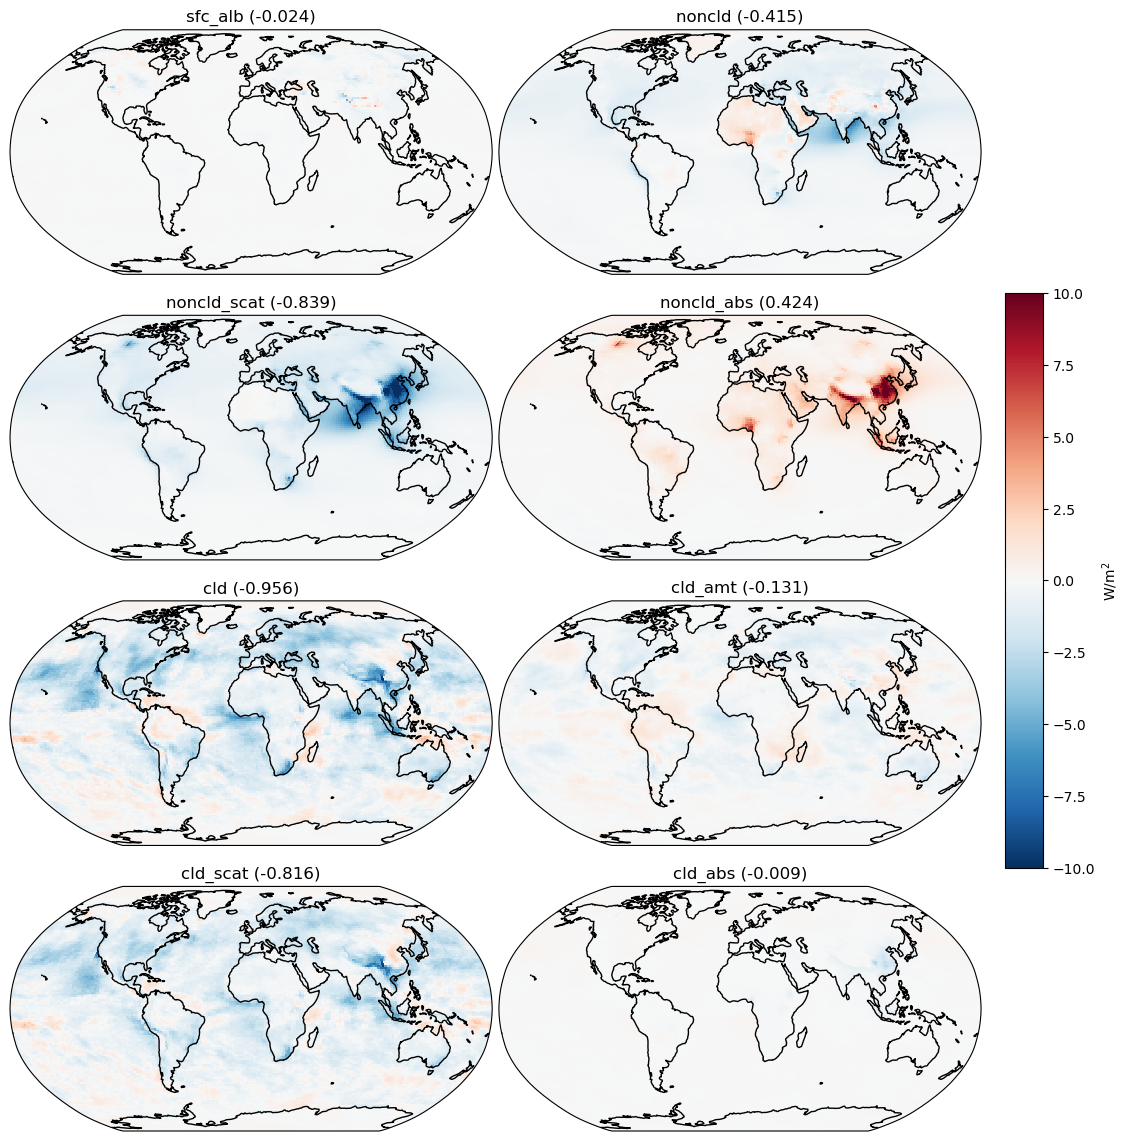

In [3]:
fields = ['sfc_alb','noncld','noncld_scat','noncld_abs','cld','cld_amt','cld_scat','cld_abs']
fig = plt.figure(figsize = (12,12))
axes = fig.subplots(nrows=4, ncols=2, subplot_kw={'projection': ccrs.Robinson()})
cnt=-1
for row in range(4):
    for col in range(2):
        cnt+=1
        var = fields[cnt]
        avgmap = ds.temporal.average(var, weighted=True)#[var]
        avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
        pl = avgmap[var].plot(ax = axes[row,col], 
                  transform=ccrs.PlateCarree(),
                  vmin = -10, vmax =  10, 
                  cmap = 'RdBu_r', 
                  add_colorbar=False)
        axes[row,col].set_title(var+" (" + str(np.round(avg,3)) + ")")
        axes[row,col].coastlines()
plt.tight_layout(w_pad=2.5,h_pad=-2)        
fig.colorbar(pl, ax=axes.ravel().tolist(), pad = 0.02, shrink = 0.5, aspect = 15, label="W/m$^2$")
        

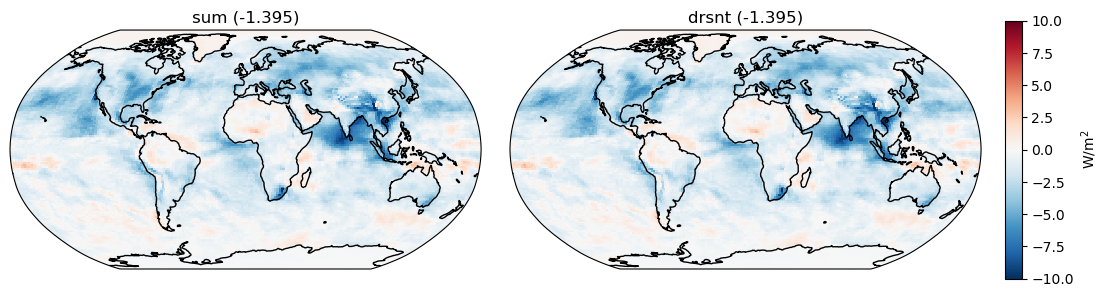

In [4]:
# Verify that the sum of APRP terms reproduces the actual change in net (down minus up) SW radiation at the TOA
ds['drsnt'] = (DATA['piClim-aer']['rsdt']-DATA['piClim-aer']['rsut']) - \
              (DATA['piClim-control']['rsdt']-DATA['piClim-control']['rsut'])
ds['sum'] = ds['sfc_alb']+ds['noncld']+ds['cld']
fields = ['sum','drsnt']
fig = plt.figure(figsize = (12,3))
axes = fig.subplots(ncols=2, subplot_kw={'projection': ccrs.Robinson()})
cnt=-1
for col in range(2):
    cnt+=1
    var = fields[cnt]
    avgmap = ds.temporal.average(var, weighted=True)#[var]
    avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
    pl = avgmap[var].plot(ax = axes[col], 
              transform=ccrs.PlateCarree(),
              vmin = -10, vmax =  10, 
              cmap = 'RdBu_r', 
              add_colorbar=False)
    axes[col].set_title(var+" (" + str(np.round(avg,3)) + ")")
    axes[col].coastlines()
plt.tight_layout(w_pad=2.5,h_pad=-2)        
fig.colorbar(pl, ax=axes.ravel().tolist(), pad = 0.02, aspect = 15, label="W/m$^2$")
        